# Exemple de notebook - filtres sql et récupération des données en pandas

L'objectif de ce notebook est de fournir des exemples pour pré-filtrer les données via sql avant de charger les données dans un DataFrame pandas.


In [ ]:
import pandas as pd

pd.set_option("display.max_columns", None)  # show all cols
pd.set_option("display.max_colwidth", None)  # show full width of showing cols
pd.set_option(
    "display.expand_frame_repr", False
)  # print cols side by side as it's supposed to be

In [ ]:
# Nous commencons par importer les librairies nécessaires pour l'analyse des données.

import duckdb

ODIS_DUCKDB_FILE = "odis.duckdb"
PCC_DUCKDB_FILE = "dev.duckdb"

con = duckdb.connect(database=PCC_DUCKDB_FILE, read_only=True)
con.sql(f"ATTACH '{ODIS_DUCKDB_FILE}' AS odis;")

## Filtres

1. Filtrer les cat nat publiées depuis 2000


In [ ]:
query_2020 = """
SELECT
	*
FROM dev.main.catnat_gaspar
WHERE dat_pub_arrete >= '2000-01-01'
ORDER BY dat_pub_arrete DESC
"""

cat_nat_2000 = con.sql(query_2020)
cat_nat_2000_df = cat_nat_2000.df()
cat_nat_2000_df.head(2)

2. Filtrer mes donées pour en récupérer une partie


In [ ]:
where_clause = """
logements."YEAR" == '2022'
"""
query_2022 = f"""
SELECT
  *
FROM odis.main."gold_gold_logements_territoires" logements
WHERE
  {where_clause}
"""

logements_2022 = con.sql(query_2022)
logements_2022_df = logements_2022.df()
logements_2022_df.head(2)

## Selectionner des colonnes avant d'exécuter la requête


Selectionner les colonnes avant de charger les données permets une exécution plus rapide et limite l'usage de la mémoire.


In [ ]:
query_rp = f"""
SELECT
  logements.codgeo,
  logements.RP as nombre_de_residences_principales
FROM odis.main."gold_gold_logements_territoires" logements
WHERE
  {where_clause}
"""
residences_principales_2022 = con.sql(query_rp)
residences_principales_2022_df = residences_principales_2022.df()
residences_principales_2022_df.head(2)

## Jointure

Joindre gold_gold_logements_territoires et gold_gold_emploi_bmo_secteurs pour croiser les données sur chaque commune :


In [ ]:
query = f"""
SELECT
  logements.codgeo,
  logements.RP as nombre_de_residences_principales,
  emploi."Commerce" as nombre_d_emplois_dans_le_commerce
FROM
  odis.main."gold_gold_logements_territoires" logements
LEFT JOIN
  odis.main."gold_gold_emploi_bmo_secteurs" emploi
    ON logements.codgeo = emploi.codgeo
WHERE
  {where_clause}
"""


joined = con.sql(query)
joined_df = joined.df()
joined_df

## Groupby et aggregats

Nombre total de prélèvements non conforme par commune en 2024


In [ ]:
query = f"""
SELECT
  logements.codgeo,
  logements.RP as nombre_de_residences_principales,
  count(*) as nombre_de_cat_nat,
  coalesce(SUM(catnat.lib_risque_jo = 'Sécheresse'), 0) as nombre_de_cat_nat_secheresse
FROM
  odis.main."gold_gold_logements_territoires" logements
LEFT JOIN
  dev.main.catnat_gaspar catnat
    ON logements.codgeo = catnat.cod_commune
WHERE
  {where_clause}
GROUP BY
  logements.codgeo,
  logements.RP
"""
grouped = con.sql(query)
grouped_df = grouped.df()
grouped_df.sort_values("nombre_de_cat_nat", ascending=False)

## Manipulation de données géographiques


Note : au moment de l'écriture de ces lignes les seules données géographiques disponibles en base sont les zones de risque de retrait-gonflement des argiles (RGA)

Note 2 : DuckDB n'a pas naturellement conscience du système de coordonnées des données qu'il contient, donc il faut y faire attention

Note 3 : Pour ces raisons si vous préférez travailler avec les données initiales sans vous encombrer de duckdb à ce niveau, elles sont sur le S3 en .gpkg ou en [shapefile ici](https://duckdb.org/2023/04/28/spatial)


In [1]:
import duckdb

PCC_DUCKDB_FILE = "dev.duckdb"

con = duckdb.connect(database=PCC_DUCKDB_FILE, read_only=True)

In [2]:
con.sql("LOAD spatial;")

Exemple : charger la table rga pour la Saône et Loire


In [3]:
import geopandas as gpd
from shapely import from_wkb

where_clause = """
rga.code_departement == '71'
"""
query = f"""
SELECT
    * EXCLUDE (geom),
    ST_AsWKB(geom) AS geom
FROM dev.main.rga
WHERE
  {where_clause}
"""

gdf = con.sql(query).df()
gdf.geom = from_wkb(gdf.geom.map(bytes))
gdf = gpd.GeoDataFrame(gdf, geometry="geom", crs="EPSG:2154")

Plot du niveau de risque


<Axes: >

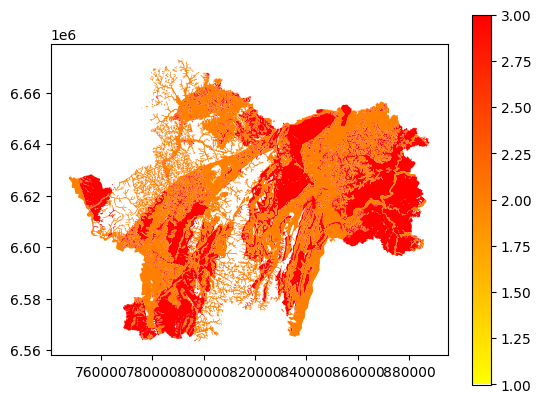

In [4]:
gdf.plot("niveau", legend=True, cmap="autumn_r")

In [ ]:
# gdf.explore("niveau", legend=True) # Si explore ne fonctionne pas très bien, sauvegardez le notebook, fermez-le et rouvrez-le

### Exporter les données si besoin


Note : le format Geojson est obligatoirement en WGS84

Note 2 : Bloc commenté par sécurité


In [ ]:
# export_geojson_query = """COPY (
#     SELECT
#         ST_FlipCoordinates(
#             ST_Transform(
#             geom, 'EPSG:2154', 'EPSG:4326'
#             )
#         ) AS geom,
#         * EXCLUDE (geom)
#     FROM dev.main.rga
#     WHERE rga.code_departement = '71'
# )
# TO 'rga.geojson'
# WITH (
#     FORMAT gdal,
#     DRIVER 'GeoJSON',
#     LAYER_CREATION_OPTIONS 'WRITE_BBOX=YES'
# );"""

# con.sql(export_geojson_query)


Ouverture du geojson et plot :


In [22]:
# gdf_geojson = gpd.read_file("rga.geojson")
# gdf_geojson.explore(
#     "niveau"
# )  # Si explore ne fonctionne pas très bien, sauvegardez le notebook, fermez-le et rouvrez-le

Ressources supplémentaires pour les données géographiques:

https://duckdb.org/2023/04/28/spatial Exemples détaillés

https://duckdb.org/docs/stable/core_extensions/spatial/overview Documentation de l'extension

https://geopandas.org/en/stable/getting_started/introduction.html Introduction à Geopandas
